In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Roof Material Classification Model

In [2]:
import pickle
import tempfile
from pathlib import Path
from types import SimpleNamespace

import geopandas as gpd
import rasterio
import torch
import matplotlib.pyplot as plt

from src.geo_utils import filter_points_to_raster
from scripts.roof_material_classification.inference import inference as roof_material_inference

/opt/conda/envs/u4u-clean-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training a Roof Material Classifier

Here is an example of how to use the roof material classification model training script:

```bash
cd scripts/roof_material_classification
python train.py --exp-version example --data-dir ../../data/processed/example_chipped_datasets/roof_material_classification/ --tile-split-file ../../config/examples/data_preprocessing/tiled_dataset_splits/tiled_dataset_splits_1.yml --output-dir ../../outputs/
```
This command initiates trainining a roof classification model using the chip dataset in the specified `data-dir`. The dataset is divided into training, validation, and test set chips according to the tile distribution defined in the `tile-split-file`. Training outputs, including model checkpoints and a pickle file containing metrics collected during training, are saved in a subdirectory of `output-dir` called `roof_material_classification`, inside another subdirectory containing the `exp-version`.

Let's plot the epoch-wise training and validation losses, the test loss of the best checkpoint (based on validation loss), and accuracy and confusion matrix:

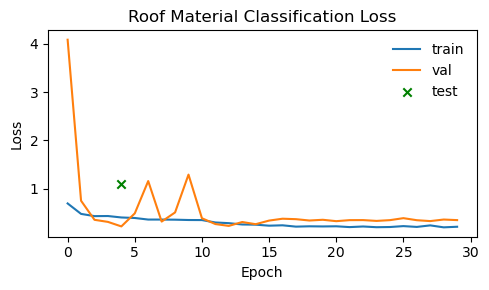

In [3]:
metrics_f = '../outputs/roof_material_classification/example-2024-01-19-01-44-00/metrics.pkl'
metrics = pickle.load(open(metrics_f, 'rb'))

# Plot train and val loss over epochs + final test loss
plt.figure(figsize=(5, 3))
plt.plot(metrics['train_losses'], label='train')
plt.plot(metrics['val_losses'], label='val')
best_epoch = metrics['val_losses'].index(min(metrics['val_losses'])) # Get epoch with best val loss
plt.scatter(best_epoch, metrics['test_loss'], label='test', color='green', marker='x')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Roof Material Classification Loss')
plt.tight_layout()
plt.show()


In [4]:
# Examine test accuracy and confusion matrix
print(metrics['label_to_class'])
print('Test accuracy: {:.2f}%'.format(metrics['test_accuracy']*100))
print('Test confusion matrix:')
print(metrics['test_confusion_matrix'])

{0: 'metal_sheet', 1: 'plastic', 2: 'thatch', 3: 'other'}
Test accuracy: 66.67%
Test confusion matrix:
[[ 8  0  0]
 [ 1 11  0]
 [ 0 11  5]]


## Running Inference with a Trained Roof Classification Model

The command below allows you to run inference using a specified checkpoint for a trained roof material classifier. The command scans the specified `image-dir` for TIFF files. For each image TIFF, it searches the specified `building-detections-dir` for a corresponding vector file of building polygons, denoted by the suffix `_buildings.gpkg`. The command uses these paired imagery and building polygons to generate input chips for the roof classifier. The predictions for each imagery file are then saved to a geopackage. This geopackage is a vector file with point geometries, each representing the center of a building polygon. The softmax score for each roof material class, as well as the argmax class, are included as data columns.

It's worth noting that in the example command below we are using the vectorized building prediction outputs from the semantic segmentation model as the source of these building polygons.
```bash
python inference.py --checkpoint-path ../../outputs/roof_material_classification/example-2024-01-19-01-44-00/checkpoints/epoch\=4_val_loss\=0.2140.ckpt --image-dir ../../data/interim/example_mosaic_cogs/ --building-detections-dir ../../outputs/semantic_segmentation/example-2024-01-19-01-06-30/inference/
```
Alternatively, we can use annotations as building polygon inputs. For example, our annotations file contains some building polygons that lack roof material labels. Let's run inference on such polygons in the Kakuma 15 region:


In [5]:
# Load annotations
annotations_f = '../data/interim/example_annotations/polygons-Kakuma_15.gpkg'
annotations = gpd.read_file(annotations_f).to_crs(32636)

# Get rows where building is not null but roof_material is null
annotations = annotations[~annotations["building"].isna() & annotations["roof:material"].isna()].copy()

# Get rows whose geometry falls within a specific imagery file extent
imagery_f = '../data/interim/example_mosaic_cogs/kakuma_15.tif'
with rasterio.open(imagery_f) as src:
    filtered_annotations = filter_points_to_raster(annotations, src)
print('Unlabeled roofs in imagery file {}: {}'.format(Path(imagery_f).name, len(filtered_annotations)))

# Create a temporary file
temp = tempfile.NamedTemporaryFile(suffix='.gpkg', delete=False)

try:
    # Save the GeoDataFrame to the temporary file
    annotations.to_file(temp.name, driver='GeoJSON')

    # Run inference
    checkpoint_f = '../outputs/roof_material_classification/example-2024-01-19-01-44-00/checkpoints/epoch=4_val_loss=0.2140.ckpt'
    out_f = '../outputs/roof_material_classification/example-2024-01-19-01-44-00/inference/epoch=4_val_loss=0.2140/kakuma_15-annotations-predictions.gpkg'
    Path(out_f).parent.mkdir(parents=True, exist_ok=True)
    args = SimpleNamespace(batch_size=64, num_workers=12, device=torch.device("cuda:0"))
    
    roof_material_inference(checkpoint_f, imagery_f, temp.name, out_f, args)

finally:
    # Ensure the temporary file with filtered annotations is deleted
    Path(temp.name).unlink()

Unlabeled roofs in imagery file kakuma_15.tif: 183


/opt/conda/envs/u4u-clean-2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/u4u-clean-2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now, we have roof material predictions for 181 out of 183 annotated buildings in Kakuma 15 that did not have roof material labels. The two that did not get predictions were excluded because their area was less than 1m^2, causing them to be filtered out.